In [19]:
import geopandas as gpd
import pandas as pd
import classes.entropycalculator as ec
from spatialentropy import altieri_entropy, leibovici_entropy
from scipy.stats import entropy
import numpy as np
import plotly.express as px

import gc
from tqdm import tqdm

wijken = gpd.read_parquet('data/wijken/wijken_stats.parquet')
gemeenten = gpd.read_parquet('data/gemeenten/gemeenten_stats.parquet')
buurten = gpd.read_parquet('data/buurten/buurten_stats.parquet')
buurten

,buurtcode,buurtnaam,wijkcode,gemeentecode,gemeentenaam,IND_WBI,H2O,POSTCODE,DEK_PERC,OAD,...,L1_shannon_0_T,L1_shannon_0_norm,L0_shannon_1_T,L0_shannon_1_norm,L1_shannon_1_T,L1_shannon_1_norm,L0_shannon_2_T,L0_shannon_2_norm,L1_shannon_2_T,L1_shannon_2_norm
0,BU00140000,Binnenstad-Noord,WK001400,GM0014,Groningen,1.0,NEE,9712,1.0,6865.0,...,4.293813,0.923831,1.961034,0.604057,3.911162,0.856103,2.147853,0.689335,3.749752,0.871942
1,BU00140001,Binnenstad-Zuid,WK001400,GM0014,Groningen,1.0,NEE,9711,1.0,6586.0,...,4.329074,0.931418,2.005446,0.617737,3.991515,0.873691,2.125112,0.682036,3.806012,0.885024
2,BU00140002,Binnenstad-Oost,WK001400,GM0014,Groningen,1.0,NEE,9711,3.0,6264.0,...,4.287841,0.922546,2.365702,0.728707,3.974084,0.869875,2.453244,0.787347,3.727877,0.866855
3,BU00140003,Binnenstad-West,WK001400,GM0014,Groningen,1.0,NEE,9718,1.0,6576.0,...,4.110712,0.884436,1.883580,0.580199,3.862138,0.845372,1.976775,0.634429,3.326029,0.773412
4,BU00140004,Noorderplantsoen,WK001400,GM0014,Groningen,1.0,NEE,9717,2.0,6447.0,...,2.124948,0.457191,2.128085,0.655514,2.128085,0.465810,2.128085,0.682991,2.128085,0.494851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13938,BU19923200,Zwartewaal,WK199232,GM1992,Voorne aan Zee,2.0,NEE,3238,1.0,281.0,...,1.236926,0.532259,1.117963,0.688732,1.260820,0.551954,1.117963,0.717601,1.260820,0.586365
13939,BU19923201,Tuindorp-Hofstede,WK199232,GM1992,Voorne aan Zee,2.0,NEE,3238,3.0,284.0,...,0.459148,0.197575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13940,BU19923202,Zalmlaan,WK199232,GM1992,Voorne aan Zee,2.0,NEE,3238,1.0,278.0,...,0.485475,0.208904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13941,BU19923209,Verspreide huizen,WK199232,GM1992,Voorne aan Zee,2.0,NEE,3238,1.0,95.0,...,1.427048,0.614071,0.772768,0.476071,1.139394,0.498797,0.772768,0.496026,1.139394,0.529894


$$E_i = \sum^{n}_{i=1}\frac{t_i(E-e_i)}{ET}$$

In [20]:
def calc_relative_entropy(row, E, T, amenity_cat, filterlevel):
    e_i = row[f"L{amenity_cat}_shannon_{filterlevel}"]
    t_i = row[f"total_amenities_{filterlevel}"]
    if (E * T) == 0:
        return 0
    return (t_i * (E - e_i)) / (E * T)


In [21]:
for i, row in tqdm(wijken.iterrows(), total=wijken.shape[0]):
    buurten_gm = buurten[buurten['wijkcode'] == row['wijkcode']]
    for filterlevel in [0, 1, 2]:
        for catlevel in [0, 1]:
            E = row[f"L{catlevel}_shannon_{filterlevel}"]
            T = row[f"total_amenities_{filterlevel}"]
            
            relative_E = buurten_gm.apply(lambda x: calc_relative_entropy(x, E, T, catlevel, filterlevel), axis=1).sum()
            wijken.at[i, f"RE_L{catlevel}_{filterlevel}"] = relative_E
            
    del buurten_gm
    gc.collect()
    
wijken.to_parquet('data/wijken/wijken_stats.parquet')
# gemeenten


100%|██████████| 3324/3324 [04:00<00:00, 13.85it/s]


<Axes: >

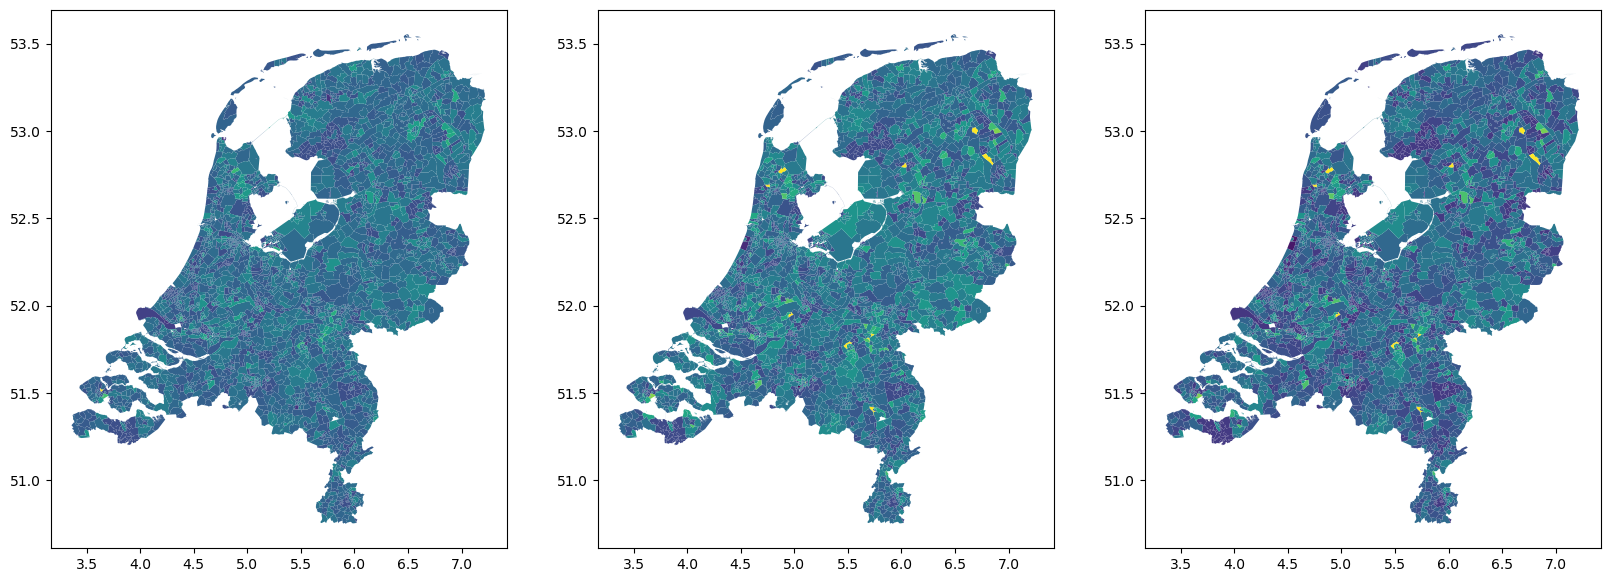

: 

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
wijken.plot(column='RE_L0_0', ax=ax[0])
wijken.plot(column='RE_L0_1', ax=ax[1])
wijken.plot(column='RE_L0_2', ax=ax[2])